In [1]:
import numpy as np
import networkx as nx

Consider a network graph denoted as $G = (V, E(\theta))$, where $V$ represents the set of nodes and $E$ signifies the edges, contingent upon a parameter vector $\theta$. The set of nodes connected to node $i$ is denoted as $a_i \subset V$. The vector $D = [\#(a_1), \#(a_2), \cdots, \#(a_N)]^T$ represents the degree of each node $i \in V$. Denote the adjacency matrix for $G$ as $\mathbf{W}$

For discrete periods $t \in [1, T]$, the state for node $i$ is denoted as $y_{it} \in \{0, 1\}$, indicating the transition of NIBRS. Let $y_t = [y_{1t}, y_{2t}, \cdots, y_{Nt}]^T$ and the augmented matrix $\mathbf{Y} = [y_1, y_2, \cdots, y_T]$ be of dimensions $N \times T$.

Assuming a diffusion process following the topology of $G$ and the local function $f_i: a_i \mapsto \{0,1\}$, we define a deterministic diffusion process as one where $f_i = 1$ if the ratio of neighboring adoption $\gamma_{it}$ exceeds a certain threshold of adoption $\tau$, else $0$. Here, $\gamma_{it}$ is given by:
$$
\gamma_{it}(y_t, G) = \begin{cases} 
    \frac{\sum_{j \in a_i} \mathbf{1}(y_{jt} = 1)}{\#(a_i)} &\quad \text{if } \#(a_i) > 0 \\
    0 & \quad \text{otherwise.}
\end{cases}
$$
The nominator part of $\gamma_{it}$ can be obtained via the matrix $\mathbf{\Gamma} = \mathbf{W}\mathbf{Y}$.
It is important to note that the cascading behavior is progressive, assuming that agencies do not reverse a transition.

The diffusion process on each state vector $y_t$ generates the predicted state for the next period, denoted as $\hat{y}_{i,t+1}(y_t, G) = \max\{\mathbf{1}(\gamma_{it} > \tau), y_{it}\}$.
The predicted state conditions solely on the current observed state and topology, independent with past observations and predictions.

The parameter of interest, $\theta$, is defined as:
$$
\theta^* = \argmin_{\theta} \sum_{i \in V} \sum_{t=1}^T (\hat{y}_{i, t+1} - y_{i, t+1})^2
$$
Or equivalently, define the $N \times (T-1)$ difference matrix $\Delta \equiv \mathbf{Y}_{t\in[2, T]} - \hat{\mathbf{Y}}_{t \in [2,T]}$.
Then the objective function can be written as the Frobenius norm of $\Delta$
$$
    \theta^* = \argmin_\theta {\Vert \Delta(\theta) \Vert}_F
$$

Note that $\theta$ determines the topology of the network, constructing different adjacency matrices, and hence $a_i = a_i(\theta)$. 

In [2]:
import networkx as nx
import numpy as np

def get_diffusion_diff(W:np.ndarray, state_dynamic: np.ndarray, th):
    """
    Calculate the squared difference between the dynamic state and the state after potential adoption
    based on a diffusion process over a network.

    Parameters:
        W : Adjacency matrix of the network
        state_dynamic (np.ndarray): Array representing the dynamic state of each node over time.

    Returns:
        float: Squared difference between the dynamic state and the state after potential adoption.
    """

    # Get the adjacency matrix of the network
    # Calculate the total number of neighbors for each node
    nodes_n = np.sum(W, axis=1, dtype=np.float64)  # Size: N x 1 matrix since sum along axis = 1

    # Calculate the sum of neighbor states for each node over time
    neighbor_state_sum_dynamic = (W @ state_dynamic).astype(float)  # Size: N x T, where T is the number of time steps

    # Calculate the adoption rate of neighbors for each node over time
        # Use np.true divide to cast type
    neighbor_adopted_rate = np.divide(neighbor_state_sum_dynamic, nodes_n,
                                      out=np.zeros_like(neighbor_state_sum_dynamic),
                                      where=nodes_n != 0)

    # Determine nodes that should adopt based on neighbor adoption rate
    agency_should_adopt = neighbor_adopted_rate > th  # Size: N x T

    # Calculate the state of each node after potential adoption
    agency_state_after_adopt = agency_should_adopt | state_dynamic  # Size: N x T

    # Calculate the squared difference between dynamic state and state after potential adoption
    diff = np.sum(
        np.square(state_dynamic[:, 1:] - agency_state_after_adopt[:, :-1])
    )  # Squared difference, Result: Scalar

    return diff


In [3]:
toy_W = np.matrix([
    [0,1,0,0,1],
    [1,0,1,1,1],
    [0,1,0,0,0],
    [0,1,0,1,0],
    [1,1,0,0,0]
]
)
toy_dynamic = np.matrix([
    [0,0,0,0,1,1,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,0,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,0,1,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,1,1,1,1,1],
])


In [4]:

get_diffusion_diff(toy_W, toy_dynamic, 0.5)

5

In [3]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

In [4]:
nibrs_df = pd.read_parquet("DATA/map_plot.pq")

node_df = pd.read_csv("th_8_q_75_node.csv")
edge_df = pd.read_csv("th_8_q_75_edge.csv")

In [5]:
G: nx.Graph = nx.from_pandas_edgelist(edge_df, "Source", "Target")
G = nx.relabel_nodes(G, dict(zip(node_df["id"], node_df["ORI9"])))

In [6]:
W = nx.adjacency_matrix(G)
nodes = list(G.nodes)

In [10]:
W.shape

(587, 587)

In [12]:
dynamic = nibrs_df[nibrs_df["ORI"].isin(nodes)].assign(y = nibrs_df["NUMBER OF MONTHS REPORTED"]>0) \
    .pivot_table(index="ORI", columns="year", values="y", aggfunc='first').fillna(False)
dynamic

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ORI,,,,,,,,,,,,,,,,,,,,,
AK0011600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AL0020100,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AL0390400,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AL0400200,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
AL0600000,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WV0290300,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,True,True,True,True,False
WV0310400,False,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,True,True,False
WV0460100,False,False,False,False,False,False,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True


In [45]:
dynamic.index

Index(['AK0011600', 'AL0020100', 'AL0390400', 'AL0400200', 'AL0600000',
       'AL0600200', 'AL0640500', 'AR0030200', 'AR0050200', 'AR0090200',
       ...
       'WI0690100', 'WI0690600', 'WV0090000', 'WV0240900', 'WV0250600',
       'WV0290300', 'WV0310400', 'WV0460100', 'WY0120200', 'WY0210100'],
      dtype='object', name='ORI', length=497)

In [34]:
G_sub = nx.subgraph(G, dynamic.index)
adj_matrix = np.matrix( nx.adjacency_matrix(G_sub, dynamic.index).toarray() )

In [35]:
adj_matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [36]:
dynamic.index

Index(['AK0011600', 'AL0020100', 'AL0390400', 'AL0400200', 'AL0600000',
       'AL0600200', 'AL0640500', 'AR0030200', 'AR0050200', 'AR0090200',
       ...
       'WI0690100', 'WI0690600', 'WV0090000', 'WV0240900', 'WV0250600',
       'WV0290300', 'WV0310400', 'WV0460100', 'WY0120200', 'WY0210100'],
      dtype='object', name='ORI', length=497)

In [37]:
benchmark_diff = get_diffusion_diff(
    adj_matrix,
    dynamic.to_numpy(dtype=int),
    0.5
)

In [38]:
benchmark_diff

1666

In [39]:
def random_wire_diff(th: float):
    if th<0 or th>1:
        raise ValueError("Threshold should be in (0,1)!")

    random_G = nx.random_degree_sequence_graph([d for n, d in G_sub.degree()])
    rand_adj_matrix = np.matrix( nx.adjacency_matrix(random_G).toarray() )
    d = get_diffusion_diff(
        rand_adj_matrix,
        dynamic.to_numpy(dtype=int),
        th
    )
    return d

In [ ]:
list_of_random = [random_wire_diff(0.5) for  _ in range(100)]

In [16]:
random_wire_diff(0.5)

1725

In [17]:
sum(benchmark_diff > diff for diff in list_of_random) / len(list_of_random)

0.0

In [18]:
list_of_random


[1680,
 1794,
 1684,
 1688,
 1555,
 1749,
 1617,
 1735,
 1776,
 1861,
 1759,
 1653,
 1640,
 1604,
 1746,
 1628,
 1705,
 1815,
 1766,
 1834,
 1663,
 1556,
 1769,
 1657,
 1616,
 1587,
 1522,
 1774,
 1615,
 1654,
 1637,
 1648,
 1741,
 1597,
 1672,
 1808,
 1715,
 1802,
 1765,
 1676,
 1816,
 1698,
 1740,
 1708,
 1673,
 1699,
 1655,
 1717,
 1670,
 1702,
 1745,
 1735,
 1741,
 1723,
 1834,
 1599,
 1683,
 1816,
 1612,
 1439,
 1820,
 1620,
 1731,
 1690,
 1653,
 1799,
 1539,
 1714,
 1674,
 1800,
 1738,
 1644,
 1607,
 1559,
 1807,
 1727,
 1703,
 1641,
 1787,
 1874,
 1707,
 1579,
 1695,
 1867,
 1724,
 1618,
 1673,
 1765,
 1674,
 1726,
 1664,
 1633,
 1801,
 1689,
 1635,
 1828,
 1847,
 1835,
 1642,
 1776]

In [41]:
th_change = []
for i in tqdm(range(1,10)):
    th = i/10.0
    list_of_random = [random_wire_diff(th) for _ in range(100)]
    th_change.append(
        sum(benchmark_diff > diff for diff in list_of_random) / len(list_of_random)
    )

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [14:13<00:00, 94.83s/it] 


In [42]:
th_change

[0.0, 0.0, 0.0, 0.0, 0.33, 0.82, 1.0, 0.99, 1.0]

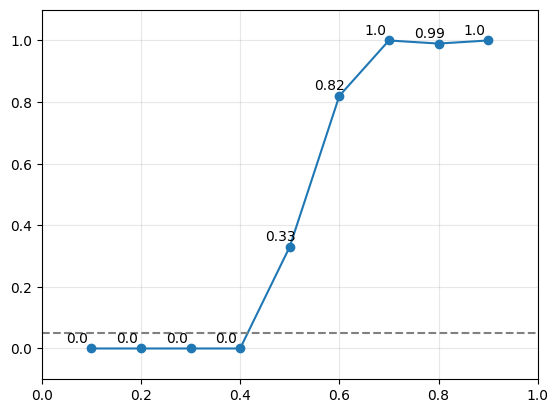

In [44]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,10)/10, th_change, '-o');
for i in range(9):
    plt.annotate(f"{th_change[i]}",((i+1)/10 -0.05 , th_change[i] + 0.02) );
plt.ylim(-0.1,1.1); plt.xlim(0,1);
plt.hlines(0.05, xmin=0, xmax=1, linestyles='--', colors='grey');
plt.grid(alpha=0.3)